# AutoEncoder for Denoising

More infos can be found on [Edward Choi youtube](https://www.youtube.com/@mp2893/featured) channel\
KAIST AI504

# Loading Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 10

# Loading Dataset

In [3]:
mnist_train = dset.MNIST("../../", train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
mnist_test = dset.MNIST("../../", train=False, transform=transforms.ToTensor(), target_transform=None, download=False)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

In [4]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Model

In [5]:
# build your own autoencoder
# in this case: 784(28*28) -> 100 -> 30 -> 100 -> 784(28*28)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),    
            nn.ReLU(),                          # activation function
            nn.Linear(100, 30),
            nn.ReLU()                           # activation function
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),                          # activation function
            nn.Linear(100, 28*28),
            nn.Sigmoid()                           # activation function
        )

                
    def forward(self, x):                # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)
        x = x.view(-1, 28*28)                          # reshape to 784(28*28)-dimensional vector
        encoded = self.encoder(x)                      # hidden vector
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)                 # final output. resize to input's size
        return out, encoded


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
model_D = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

# Training

In [8]:
import time
import copy

# It's all the same except for one: adding noise to inputs
# copy train_model() code and just add 'noise part'
# You can make noise like this.
# noise = torch.zeros(inputs.size(0), 1, 28, 28)
# nn.init.normal_(noise, 0, 0.1)

def train_model_D(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                noise = torch.zeros(inputs.size(0), 1, 28, 28)
                nn.init.normal_(noise, 0, 0.1)
                noise = noise.to(device)
                inputs = inputs.to(device)
                noise_inputs = inputs + noise

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(noise_inputs)
                    loss = criterion(outputs, inputs)           # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [9]:
best_model_D, train_loss_history_D, val_loss_history_D = train_model_D(model_D, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.1160
val Loss: 0.0704

Epoch 1/9
----------
train Loss: 0.0665
val Loss: 0.0625

Epoch 2/9
----------
train Loss: 0.0582
val Loss: 0.0532

Epoch 3/9
----------
train Loss: 0.0485
val Loss: 0.0444

Epoch 4/9
----------
train Loss: 0.0415
val Loss: 0.0389

Epoch 5/9
----------
train Loss: 0.0370
val Loss: 0.0354

Epoch 6/9
----------
train Loss: 0.0340
val Loss: 0.0327

Epoch 7/9
----------
train Loss: 0.0315
val Loss: 0.0306

Epoch 8/9
----------
train Loss: 0.0297
val Loss: 0.0290

Epoch 9/9
----------
train Loss: 0.0282
val Loss: 0.0275

Training complete in 2m 6s
Best val Loss: 0.027491


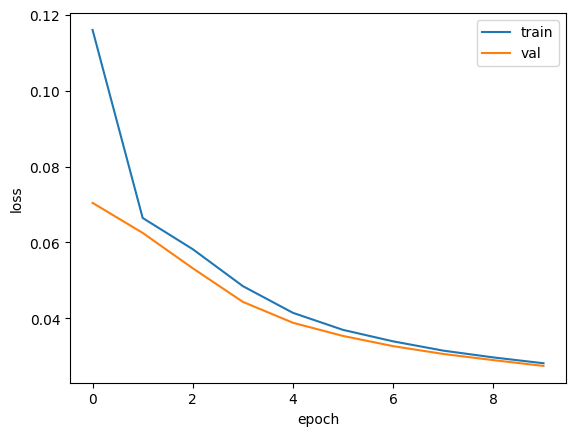

In [10]:
plt.plot(train_loss_history_D, label='train')
plt.plot(val_loss_history_D, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Testing

In [11]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders['test']:
        noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1)
        noise = noise.to(device)
        inputs = inputs.to(device)
        noise_inputs = inputs + noise

        outputs, encoded = best_model_D(noise_inputs)
        test_loss = loss_func(outputs, inputs)

        running_loss += test_loss.item()* inputs.size(0)
        
    test_loss = running_loss / len(dataloaders['test'].dataset)
    print(test_loss) 

0.026960013857483863


# AE Reconstruction From Noise

torch.Size([16, 28, 28])


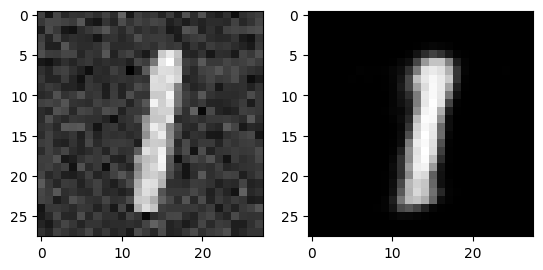

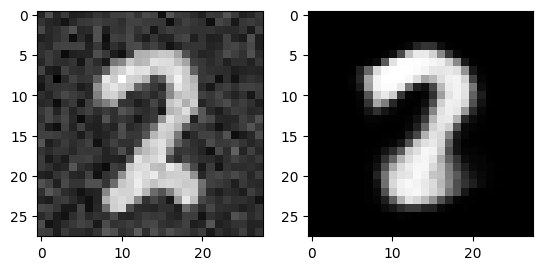

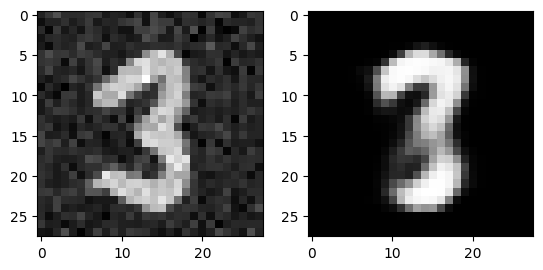

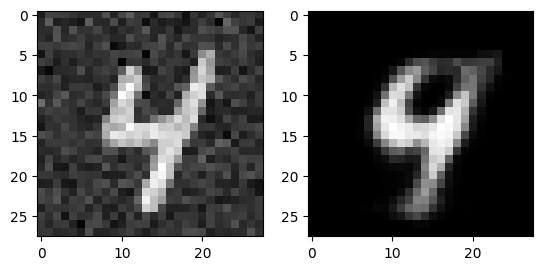

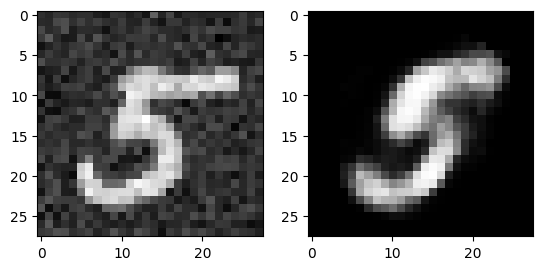

In [12]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(noise_inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()